<a href="https://colab.research.google.com/github/Daiyan-Zubaier/Stock-Price-Predictor/blob/main/Stock_Predictor_Daiyan_%26_Rajit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/jinglescode/time-series-forecasting-pytorch

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# To fetch stock market data
!pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries

print("All libraries loaded")

All libraries loaded


# Configuration Settings
Configures settings for libraries in a 2D hashmap


In [4]:
config = {
    #Collects stock price data
    "alpha_vantage": {
        "key": "CX2NAREQLV2VVYIV",
        "symbol": "IBM",
        # Or use Compact for last 100 days
        "outputsize": "full",
        "key_adjusted_close": "4. close",
    },
    #Data preprocessing settings
    "data": {
        # number of past days to predict next price
        "window_size": 20,
        # 80% for training, 20% for testing
        "train_split_size": 0.80,
    },
    # Plotting settings
    "plots": {
        # Show data label every x days
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    # LSTM NN Settings
    "model": {
        # Number of features
        "input_size": 1,
        "num_lstm_layers": 2,
        "lstm_size": 32,
        # Disables neurons
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu",
        "batch_size": 64,
        # Train for x cycles
        "num_epoch": 100,
        "learning_rate": 0.01,
        # Decreasing lr every x epochs
        "scheduler_step_size": 40,
    }
}

Number data points 6363 from 1999-11-01 to 2025-02-18
[ 96.75  94.81  94.37 ... 259.19 261.28 263.07]
[ 96.75  94.81  94.37 ... 259.19 261.28 263.07]
6363
from 1999-11-01 to 2025-02-18


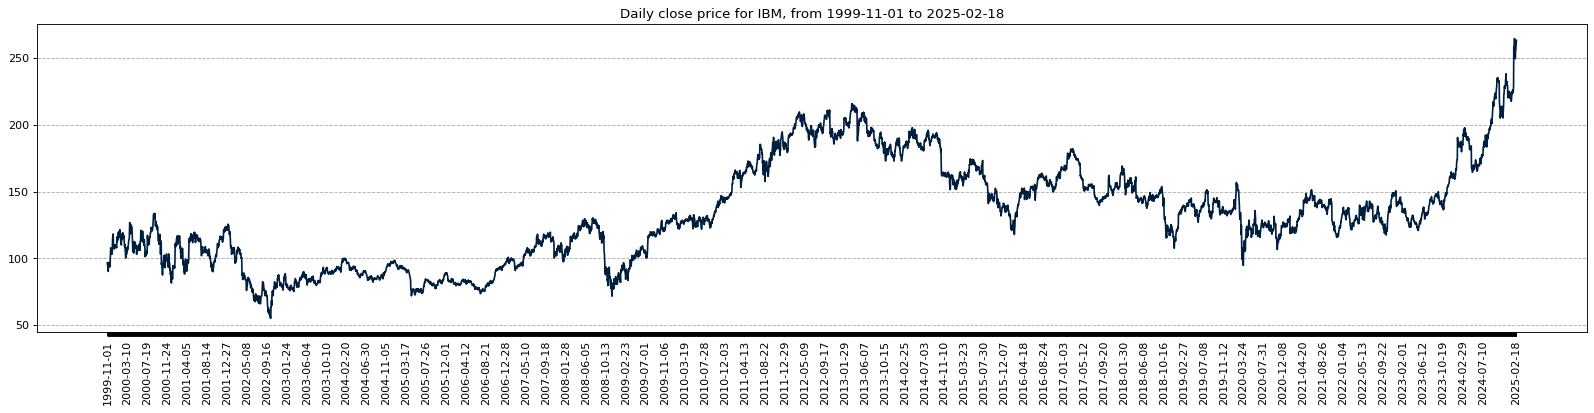

In [5]:
import requests

def download_data(config):
    url = 'https://www.alphavantage.co/query'
    params = {
        'function': 'TIME_SERIES_DAILY',
        'symbol': config["alpha_vantage"]["symbol"],
        'outputsize': config["alpha_vantage"]["outputsize"],
        'apikey': config["alpha_vantage"]["key"]
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "Error Message" in data:
        raise ValueError(data["Error Message"])

    # Extract data
    data_date = list(data['Time Series (Daily)'].keys())
    data_date.reverse()

    data_close_price = [float(data['Time Series (Daily)'][date]['4. close']) for date in data['Time Series (Daily)'].keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)        # number of available dates.
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points - 1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range
'''
data_date: List of dates.
data_close_price: NumPy array of closing prices.
num_data_points: Total number of data points.
display_date_range: A string indicating the range of dates.
'''

data_date, data_close_price, num_data_points, display_date_range = download_data(config)
print(data_close_price)
print(data_close_price)
print(num_data_points)
print(display_date_range)

# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(visible=True, which='major', axis='y', linestyle='--')
plt.show()

In [6]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

In [7]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

## Dataloader class

Based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
Our class is a map-style dataset

In [9]:
class StockDataset(Dataset):
    def __init__(self, x, y):
        # expanding dimension of array, currently (batch, window), after (batch, window, features)
        x = np.expand_dims(x, 2)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

print("data_x_train", data_x_train.shape)
print("data_x_val", data_x_val.shape)
train_dataset = StockDataset(data_x_train, data_y_train)
val_dataset = StockDataset(data_x_val, data_y_val)

print("Train data shape", train_dataset.x.shape, train_dataset.y.shape)
print("Validation data shape", val_dataset.x.shape, val_dataset.y.shape)

train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

data_x_train [[-0.95992859 -1.0113926  -1.02306485 ... -0.75433782 -0.7410739
  -0.76256145]
 [-1.0113926  -1.02306485 -1.09760808 ... -0.7410739  -0.76256145
  -0.79253791]
 [-1.02306485 -1.09760808 -1.13235955 ... -0.76256145 -0.79253791
  -0.78298789]
 ...
 [ 0.06192384 -0.00333464  0.0292946  ...  0.26353544  0.20225612
   0.15079211]
 [-0.00333464  0.0292946   0.06590302 ...  0.20225612  0.15079211
   0.175463  ]
 [ 0.0292946   0.06590302  0.03725295 ...  0.15079211  0.175463
   0.12612122]]
data_x_val (1269, 20)
Train data shape (5074, 20, 1) (5074,)
Validation data shape (1269, 20, 1) (1269,)
